# 残差診断

If you come here without expecting Japanese, please click [Google translated version](https://translate.google.com/translate?hl=&sl=ja&tl=en&u=https%3A%2F%2Fpy4etrics.github.io%2F10_Residuals.html) in English or the language of your choice.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import norm, uniform
import lmdiag
import statsmodels.api as sm

## 説明

**＜目的＞**

実際に回帰分析をする際，少なくとも２つの問題が存在する。

* 母集団回帰式自体が正しいかどうか（モデルの特定化の問題）。
* GM仮定1,4,5は観測できない母集団回帰式の誤差項に関するものだが，これらの仮定が成立するかどうか。

これらは重要な問題であり，非常に難しい問題でもある。１つの対処方法として，誤差項の推定値である残差の値の分布など図示して大まかな判断をする方法がある。ここではこの手法について考えることにする。

**＜内容＞**
1. 残差と$R^2$
    * 残差と決定係数の関係をシミュレーションで確認する。
1. 「理想的な」残差の分布
    * 標本の大きさによって残差の散布図がどう変化するかを確かめる。
1. 回帰診断
    * 回帰結果の「健康状態」を示すパッケージ`lmdiag`を紹介する。
1. 問題がある残差の例
    * `lmdiag`を使って確認する。

## 残差と$R^2$

### 説明

回帰分析のシミュレーションをおこない残差の分布と$R^2$の関係を図を使っておさらいする。

---
単回帰のシミュレーション用の関数`ols_sim`を定義する。
* 引き数
    1. 標本の大きさ`n`
    1. 誤差項の標準偏差`u_sd`
* 返り値
    1. 説明変数 $x$
    1. 被説明変数 $y$
    1. 予測値 $\hat{y}$
    1. 残差 $u$
    1. 標準化残差
        * 残差$u$は母集団の誤差項の推定値であるが，$u$を使い誤差項の性質について調べるには限度があることが知られている。その代わりになるのが「標準化残差」である。$u$をある統計量で除して標準化した残差であり，観測できない誤差項についてより正確な情報が得られる。
        * `OLS`の結果のメソッド`get_influence()`を使い，その属性`.resid_studentized_internal`で取得する
        * 英語では**Internally Studentized Residuals**もしくは**Standardized Residuals**と呼ばれる。
    1. $R^2$

In [2]:
def ols_sim(n, u_sd):  # n=標本の大きさ，　u_sd=誤差項の標準偏差
    
    x = uniform.rvs(1, 10, size=n)  # 説明変数
    u = norm.rvs(scale=u_sd, size=n)  # 誤差項
    y = 1.0 + 0.5*x + u               # 被説明変数
    
    df = pd.DataFrame({'Y':y, 'X':x})  # DataFrame
    
    res = ols(formula='Y ~ X', data=df).fit()  # OLSの計算
    u_standardized = res.get_influence().resid_studentized_internal  # 標準化残差
    
    return x, y, res.fittedvalues, res.resid, u_standardized, res.rsquared  # 返り値の設定

この関数を使い$R^2$が高いケースと低いケースを別々にシミュレーションを行う。返り値の順番に合わせて代入する変数を並べる。（添え字の`high`と`low`は「高いケース」と「低いケース」を表す。）

In [3]:
# R^2が高いケース
x_high, y_high, y_fit_high, resid_high, resid_st_high, r2_high = ols_sim(50, 0.5)

# R^2が低いケース
x_low, y_low, y_fit_low, resid_low, resid_st_low, r2_low = ols_sim(50, 1.5)

ここでは以下のように変数を定義している（`high`と`low`の添字は省いている）：
* `x`: 説明変数
* `y`: 被説明変数
* `u`: 誤差項
* `f_fit`: 予測値
* `resid`: 残差
* `resid_st`: 標準化残差
* `r2`: 決定係数

まず決定係数の値を確認する。（注意）以前説明した`f-string`を使っている。

In [4]:
print(f'決定係数が高いケース: {r2_high:.3f}\n決定係数が高いケース: {r2_low:.3f}')

決定係数が高いケース: 0.871
決定係数が高いケース: 0.567


上のコードで`:.3f`が付け加えられているが，表示する小数点を第三位までと指定するオプション。

### 散布図と回帰直線

図を並べて描くために，`matplotlib`の`subplots()`を使う。

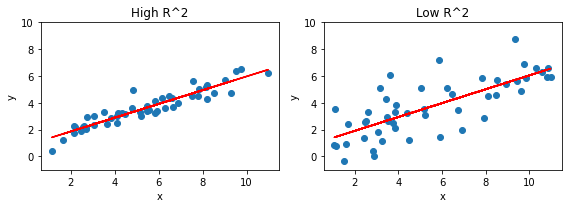

In [5]:
plt.figure(figsize=(8,3))  # figsizeは左右２つの図を合わせた大きさ

# 左の図
plt.subplot(121)
plt.scatter(x_high,y_high)  # 散布図
plt.plot(x_high, y_fit_high,color='red')  # 回帰線
plt.ylim(-1,10)  # 縦軸の表示幅を設定
plt.xlabel('x')  # 横軸のラベル
plt.ylabel('y')  # 縦軸のラベル
plt.title('High R^2')  # タイトル

# 右の図
plt.subplot(122)
plt.scatter(x_low,y_low)
plt.plot(x_low, y_fit_low, color='red')
plt.ylim(-1,10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Low R^2')

plt.tight_layout();  # 左右の間に余裕も持たせる

回帰直線のフィット感ははっきりと決定係数の値に現れている。

### 残差

次に予測値$\hat{y}$と残差$\hat{u}$の散布図を描いてみる。

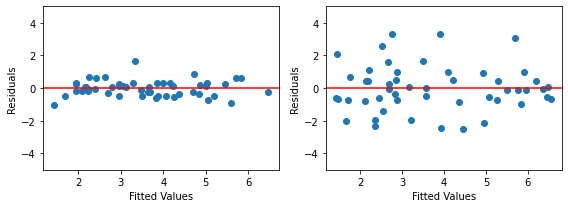

In [6]:
plt.figure(figsize=(8,3))

# 左の図
plt.subplot(121)
plt.scatter(y_fit_high,resid_high)
plt.axhline(y=0, color='red')  # 縦軸の値が0での平行線
plt.ylim(-5,5)  # 縦軸の表示幅を指定
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

# 右の図
plt.subplot(122)
plt.scatter(y_fit_low,resid_low)
plt.axhline(y=0, color='red')
plt.ylim(-5,5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.tight_layout();

ここでも決定係数の値との関係がハッキリとわかる。

### 標準化残差

予測値と標準化残差の散布図を図示する。

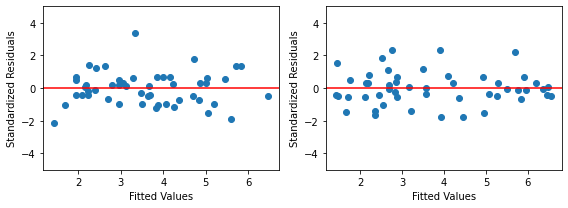

In [7]:
plt.figure(figsize=(8,3))

# 左の図
plt.subplot(121)
plt.scatter(y_fit_high,resid_st_high)
plt.axhline(y=0, color='red')  # 縦軸の値が0での平行線
plt.ylim(-5,5)  # 縦軸の表示幅を指定
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')

# 右の図
plt.subplot(122)
plt.scatter(y_fit_low,resid_st_low)
plt.axhline(y=0, color='red')
plt.ylim(-5,5)
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')

plt.tight_layout();

左右ともに散らばりの差はあまりない。もちろん，理由は平均`0`，分散`1`になるように「標準化」されているためである。

## 「理想的な」残差の分布

GM仮定1,4,5が成立する場合，残差は平均`0`で分散が一定なランダムな分布になる。ここでは，そのような「理想的な残差」はどのようなものかを図示し，標本の大きさによってどのように見えるのかを確認する。正規分布の確率変数を「理想的な残差」として考える。

まず図示するための関数を定義する。
* 引き数
    * 標本の大きさ：`n`
    * （残差の）標準偏差：`u_sd`
* 返り値
    * 散布図

In [8]:
def resid_ideal(n, u_sd):
    
    xx = list(range(n))  # 0から始まるｎ個の整数のリスト
    u = norm.rvs(scale=u_sd, size=n)   # 正規分布に従うn個の「残差」
    
    return plt.scatter(xx,u), \
           plt.axhline(y=0,color='red'), \
           plt.xlabel('n'), \
           plt.ylabel('Residuals'), \
           plt.title('Ideal Residuals')

この関数の返り値は`matplotlib`のコードである。返り値として図が表示されることになる。

---
標準偏差`1`の$n=2000$の残差

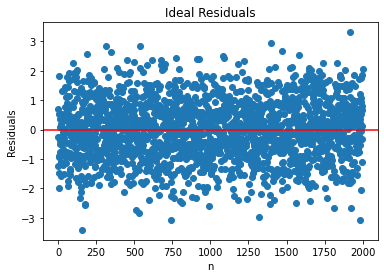

In [9]:
resid_ideal(2000, 1);

`0`の周りに均等に分散しているのが確認できる。

---
標準偏差`1`の$n=500$の残差

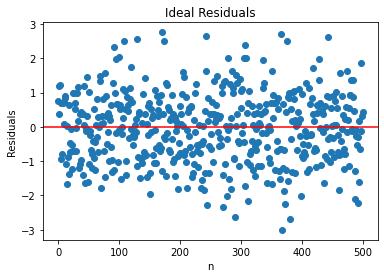

In [10]:
resid_ideal(500, 1);

観測値の間隔は少し広がっているが，シミュレーションによっては$n=2000$と比べて大きな変化は見られない場合もあれば，「外れ値」が気になる場合もあるかも知れない。

---
標準偏差`1`の$n=100$の残差

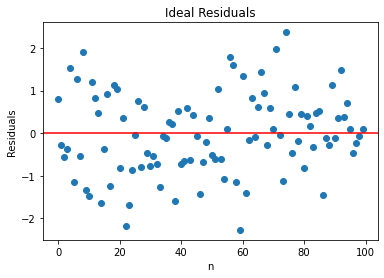

In [11]:
resid_ideal(100, 1);

さらに隙間が広くなっている。シミュレーションによっては，少し偏りがあるように見える場合も発生するため，上の例と比べると，GM仮定1,4,5に関して自信を持って判断しづらくなる。

---
標準偏差`1`の$n=30$の残差

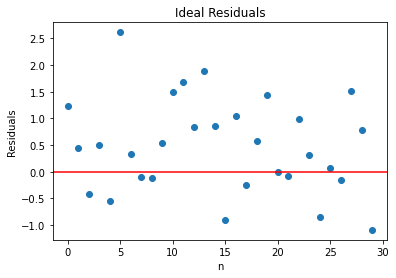

In [12]:
resid_ideal(30, 1);

正規分布と分かって眺めるとそう見えるかも知れないが，実際の実証分析を行う上でこの図だけでGM仮定1,4,5が満たされているかどうかを判断するのは難しい。

---
標準偏差`1`の$n=20$の残差

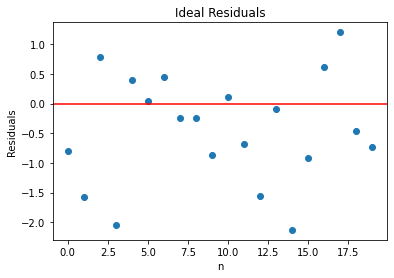

In [13]:
resid_ideal(20, 1);

標本の大きさが小さい場合，観測数が`10`少なくなると図が大きく違うように見える。

## 回帰診断：`lmdiag`

### 説明

上で見たように，残差を単に図示しただけでは「理想的な残差」からどれだけ乖離しているかを判断するのは難しいところがある。標本の大きさが小さい場合は特にそうである。ではどのように対処すれば良いのか。１つの方法が，計量経済学のソフトウェア`R`に実装されている残差を図示するコマンドである。これにより回帰式の定式化に「失敗」がないかをある程度確認することができる。ここではその内の４つの図を自動で描くことができるパッケージ`lmdiag`を紹介する。「正常」なパターンから著しく異なる場合，回帰式の修正の必要性を知らせる「早期警戒システム」と思えば良いだろう。

まずGM仮定1~6の全ての仮定が満たされる場合を考え，`lmdiag`のコマンドを説明する。その後，問題が疑われるケースではどのような図になるかを示すことにする。

次のシミュレーションを考えよう。

In [14]:
n = 50  # 標本の大きさ

x = norm.rvs(loc=4, scale=1, size=n)  # 説明変数
u = norm.rvs(size=n)  # 誤差項（標準正規分布）
y = 1 + 0.5*x + u  # 説明変数

df_diag = pd.DataFrame({'Y':y, 'X':x})  # DataFrameの作成

res_diag = ols(formula='Y ~ X', data=df_diag).fit()  # OLS推定

### `resid_fit()`関数

* 横軸：$y$の予測値 $\hat{y}$
* 縦軸：残差 $\hat{u}$

（目的）

残差に非線形のパターンがないかを確認する。縦軸の`0`を中心に上下にランダムに散らばっている場合，回帰式は線形と判断できるが，上向きやU字型や何らかのパターンがあると非線形の可能性が示唆される。
* 赤の線は残差の散らばりに「最も」フィットする曲線
    * 縦軸`0`の平行線（点線）が理想的
* 絶対値が最も大きい３つの残差にインデックスの数字が示されている。

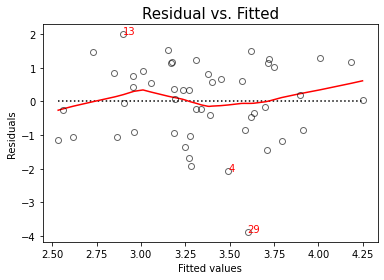

In [15]:
lmdiag.resid_fit(res_diag)
pass

回帰分析結果の「健康状態」を診断する上でこの図は最もよく使われる。この図について以下の点を覚えておこう。
* 残差$\hat{u}$は観測できない母集団回帰式の誤差項$u$の推定である。
* $y$の予測値は$\hat{y}=\hat{\beta}_0+\hat{\beta}_1x$である。従って，もし残差$\hat{u}$と$x$に何らかの関係があれば，残差$\hat{u}$と予測値$\hat{y}$の関係に現れる。
* GM仮定4を思い出そう。誤差項の条件つき期待値が`0`$E(u|X)=0$という仮定である。
    * この仮定が正しければ，残差$\hat{u}$の平均は`0`あり，図の赤い線は`0`で横軸と並行になることを意味している。
    * この仮定が満たされず，説明変数$x$が何らかの形で$\hat{u}$に影響を与えているのであれば，その影響は上の図に現れてくる。（下の「問題がある残差の例」を参照）。

### `q_q()`関数

`qq`プロットとも呼ばれる。`q`は`quantile`（分位数）のこと。

* 横軸：横軸に正規分布の理論値
* 縦軸：標準化残差（standardized residuals）
    * 標準化残差とは平均`0`，分散`1`に変換した残差

（目的）

残差が正規分布に従っているかを確認する。データが正規分布に従っている場合，データは45度線（赤の点線）に沿って分布することになる。多くの残差が概ね45度線近傍にあれば他の図を確認する程度でよい。しかし多くの残差が45度線から外れている場合は，正規分布ではない可能性が大きくなる。

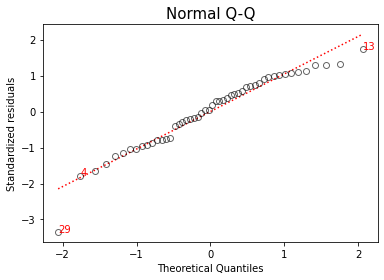

In [16]:
lmdiag.q_q(res_diag)
pass

### `scale_loc()`関数

* 横軸：$y$の予測値$\hat{y}$
* 縦軸：標準化残差（standardized residuals）の絶対値のルート
    * 標準化残差とは平均`0`，分散`1`に変換した残差

（目的）

残差が均一分散かどうかを確認する。縦の散らばりが概ね均等であれば均一分散と解釈できるが，何らかのパターンがあれば不均一分散の可能性がある。
* 赤の線は残差の散らばりに「最も」フィットする曲線
    * 横軸に平行となるのが理想的
* 絶対値が最も大きい３つの残差にインデックスの数字が示されている。

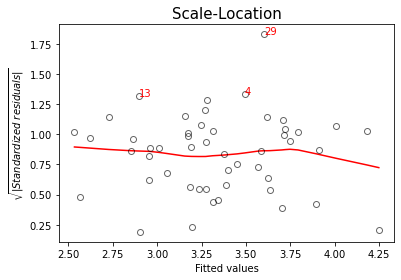

In [17]:
lmdiag.scale_loc(res_diag)
pass

### `resid_lev()`関数

* 縦軸：標準化残差（standardized residuals）
    * 残差を標準偏差で除して平均`0`，分散`1`に変換した残差
    * 99.7%の確率で`(-3,3)`の間に入る
    * 観測値$y_i$が予測値$\hat{y}$からどれだけ離れているかを示す（外れ値＝outlier）。縦軸の絶対値が大きい（例えば、絶対値３以上）と外れ値の可能性が高まる。
    * この距離が長くなると（絶対値が大きくなると），推定値$\hat{\beta}_1$に大きな影響力をもつ**可能性**が高くなる。
* 横軸：レバレッジ（leverage）
    * 説明変数がどれだけ「極端」な値を取るかを示す。
    * 単回帰の場合
        * 説明変数$x_i$と平均の$x$の間の距離を示す。
        * この距離が長くなると，推定値$\hat{\beta}_1$に影響力をもつ**可能性**が高くなり，高いレバレッジの値として反映される。
    * 重回帰の場合
        * 説明変数$x_{ij},\;j=1,2,..,k$のうち１つ以上の説明変数の値が極端に大きい場合や小さい場合にレバレッジは高くなる。また説明変数の値の組み合わせが「通常」ではない場合にもレバレッジは高くなる。

（影響力がある観測値）
* レバレッジと標準化残差の**絶対値**の両方が大きい観測値

（目的）

OLS推定値を計算する上で影響力が大きい観測値を特定し，推定値が小数の観測値に大きく左右されていないかを確認する。そのような影響力がある観測値は図の右上と右下に現れ，特に点線（Cook's Distanceと呼ばれる）の外（右上と右下）にある場合は要注意（右の真ん中のエリアは重要ではない）。観測値の散らばりやそのパターンは関係ない。
* 赤い点線：Cook's Distance (CD)
    * ある観測値を外して再計算するとどれだけ予測値$\hat{y}$が変化するかを数値化したもの。
    * 内側の点線：CD = 0.5
    * 外側の点線：CD = 1
* 赤い線は観測値にフィットする曲線
* 最も影響力が大きい観測値にインデックスの数字が示されている。

---
下の図では`CD`の赤い点線は出ていない。

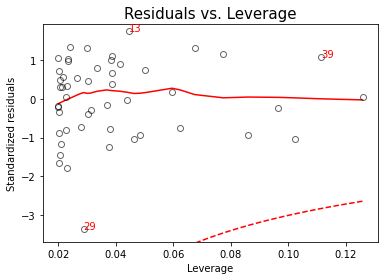

In [18]:
lmdiag.resid_lev(res_diag)
pass

### `plot()`：４つの図を同時に表示

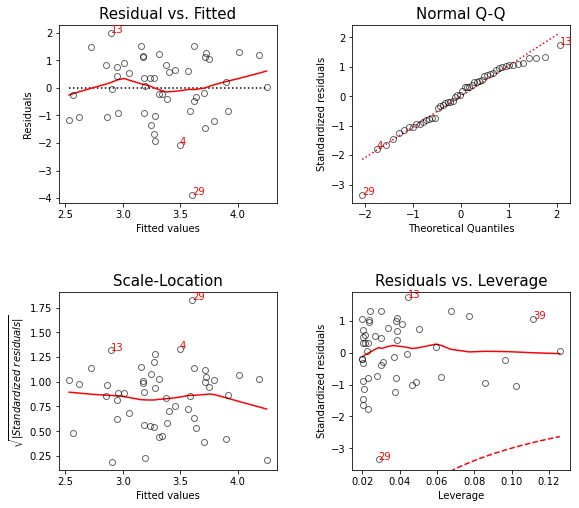

In [19]:
plt.figure(figsize=(8,7))
lmdiag.plot(res_diag)
pass

## `qq`プロット（again）

`qq`プロットを表示する代替方法として，`statsmodels`の`qqplot`モジュールがある。ここではその使い方を簡単に説明する。

`statsmodels`自体を`sm`として読み込んでいる。

＜の使い方＞
```
    sm.qqplot(引数，fit=True, line='45)
```
* 引数：回帰結果の残差を指定する。上の例では`res_diag.resid`。
* オプション`fit`：残差の平均・標準偏差を自動的に計算することを指定する。
* オプション`line`：は45度線を表示する。

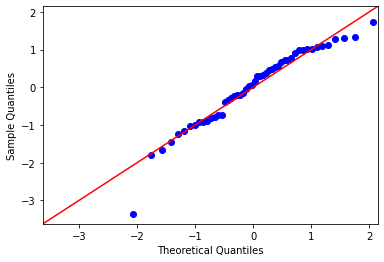

In [20]:
sm.qqplot(res_diag.resid, fit=True, line='45')
pass

## 問題がある残差の例

### ケース１：被説明変数の変換が必要な回帰式

この例では以下を想定する。
* 母集団回帰式

    $$\ln y = \beta_0 + \beta_1 x + u $$
    
* 標本回帰式

    $$y_i = \beta_0 + \beta_1 x_i + u_i$$

（解決方法）

$y$を対数変換する。

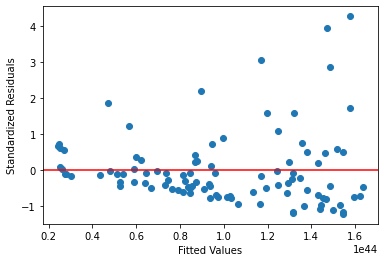

In [21]:
n = 100  # 標本の大きさ

x = uniform.rvs(1, 10, size=n)  # 説明変数
u = norm.rvs(scale=1, size=n)  # 誤差項
y = np.exp(100.0 + .1*x + u)   # 被説明変数

df = pd.DataFrame({'Y':y, 'X':x})  # DataFrame

res = ols(formula='Y ~ X', data=df).fit()  # OLSの計算
resid_std = res.get_influence().resid_studentized_internal  # 標準化残差

plt.scatter(res.fittedvalues,resid_std)  # 散布図
plt.axhline(y=0, color='red')          # 赤い平行線
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
pass

`lmdiag`パッケージを使う。

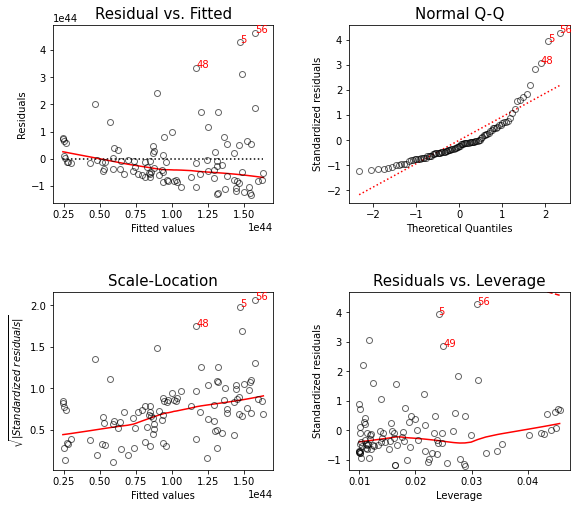

In [22]:
plt.figure(figsize=(8,7))
lmdiag.plot(res)
pass

### ケース２：説明変数の２乗項の欠落

この例では以下を想定する。
* 母集団回帰式

    $$y = \beta_0 + \beta_1 x + \beta_2 x^2+ u $$
    
* 標本回帰式

    $$y_i = \beta_0 + \beta_1 x_i + u_i$$

（解決方法）

標本回帰式に$x^2$を加える。

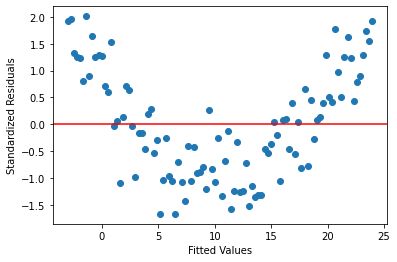

In [23]:
n = 100
x = np.linspace(0,16,n)
x2 = x**2
u = norm.rvs(scale=1, size=n)
y = 1.0 + 0.1*x +0.1*x2+ u
df = pd.DataFrame({'Y':y, 'X':x})

res = ols(formula='Y ~ X', data=df).fit()
resid_std = res.get_influence().resid_studentized_internal

plt.scatter(res.fittedvalues,resid_std)
plt.axhline(y=0, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
pass

`lmdiag`パッケージを使う。

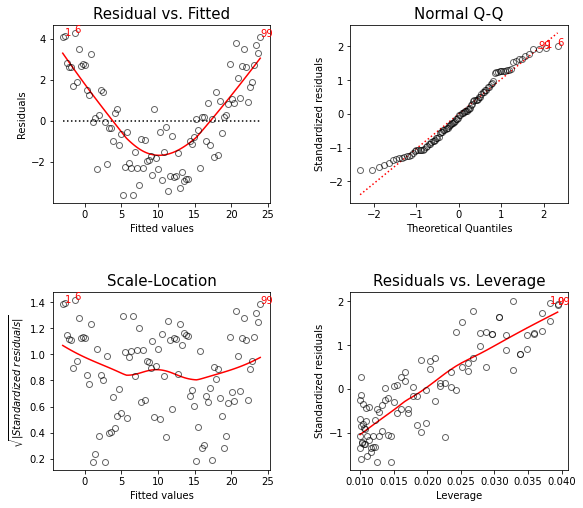

In [24]:
plt.figure(figsize=(8,7))
lmdiag.plot(res)
pass

### ケース３：定数項がある条件により変化する場合

この例では以下を想定する。（以下にある「条件１」と「条件２」が何らかの理由で成立すると仮定する。）
* 母集団回帰式

    $$
    y = 
    \left\{
        \begin{split}
            &\delta_0 + \beta_1 x + u\quad\text{条件１の場合} \\
            &\gamma_0 + \beta_1 x + u\quad\text{条件２の場合}
        \end{split}
    \right.
    $$
    
* 標本回帰式

    $$y_i = \beta_0 + \beta_1 x_i + u_i$$

（解決方法）

ダミー変数を使う。

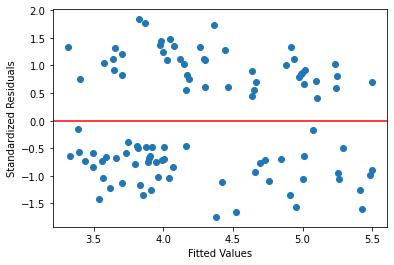

In [25]:
n = 100

b0 = np.random.choice([1,7], n, p=[0.5,0.5])
x = uniform.rvs(0,10,size=n)
u = norm.rvs(scale=1, size=n)
y = b0 + 0.1*x + u

df = pd.DataFrame({'Y':y, 'X':x})

res = ols(formula='Y ~ X', data=df).fit()
resid_std = res.get_influence().resid_studentized_internal

plt.scatter(res.fittedvalues,resid_std)
plt.axhline(y=0, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
pass

`lmdiag`パッケージを使う。

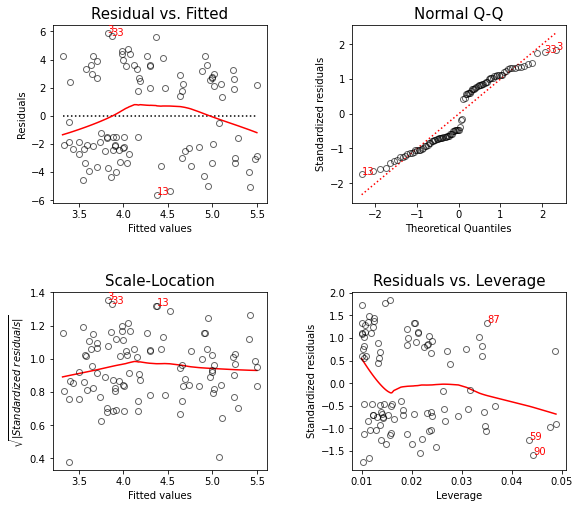

In [26]:
plt.figure(figsize=(8,7))
lmdiag.plot(res)
pass

### ケース４：不均一分散

この例では以下を想定する。
* 母集団回帰式

    $$y = \beta_0 + \beta_1 x + u(x) $$
    
    * 誤差項が説明変数に依存し，不均一分散となる。
    * （理由）欠落変数など
* 標本回帰式

    $$y_i = \beta_0 + \beta_1 x_i + u_i$$

（解決方法）
* 説明変数を追加し欠落変数をなくす。
* 変数の変換（対数化など）
* 可能な推定方法を試す
    * 加重最小二乗法（Weighted Least Squares）
    * 操作変数法
    * パネル推定法

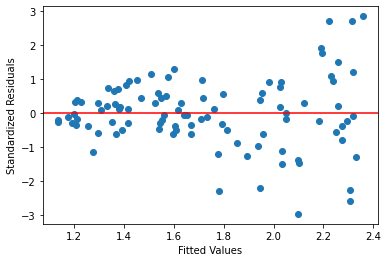

In [27]:
n = 100
x = uniform.rvs(0,10,size=n)
u = norm.rvs(scale=1, size=n)
y = 1 + 0.1*x + x**0.6*u
df = pd.DataFrame({'Y':y, 'X':x})

res = ols(formula='Y ~ X', data=df).fit()
resid_std = res.get_influence().resid_studentized_internal

plt.scatter(res.fittedvalues,resid_std)
plt.axhline(y=0, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Standardized Residuals')
pass

`lmdiag`パッケージを使う。

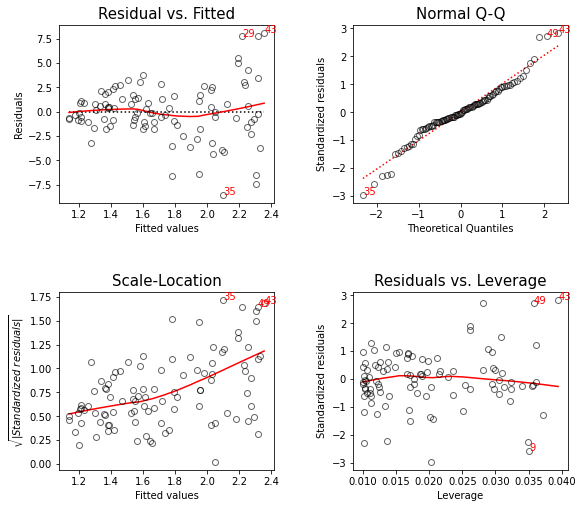

In [28]:
plt.figure(figsize=(8,7))
lmdiag.plot(res)
pass

### ケース５：小数の観測値に影響される場合：高いレバレッジ

ここでは推定値が１つの観測値に大きく左右される場合を考える。

In [29]:
np.random.seed(123)

n = 20
x = norm.rvs(loc=20, scale=3, size=n)
u = norm.rvs(size=n)
y = 5 + 0.5*x + u

# 外れ値を追加する
x = np.append(x, 30)
y = np.append(y, 10)
df_cd = pd.DataFrame({'Y':y, 'X':x})

# 外れ値がない場合のOLS
res_no = ols(formula='Y ~ X', data=df_cd.loc[0:19,:]).fit()

# 外れ値がある場合のOLS
res_cd = ols(formula='Y ~ X', data=df_cd).fit()

回帰曲線の図示

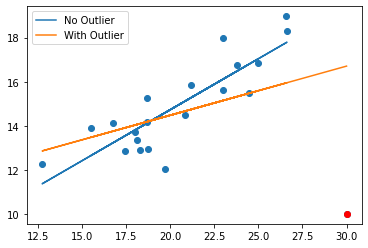

In [30]:
plt.scatter(x,y)
plt.scatter(30,10, color='red')  # 外れ値
plt.plot(x[:20],res_no.fittedvalues, label='No Outlier')
plt.plot(x,res_cd.fittedvalues, label='With Outlier')
plt.legend()
pass

外れ値（赤の観測値）がない場合の回帰診断

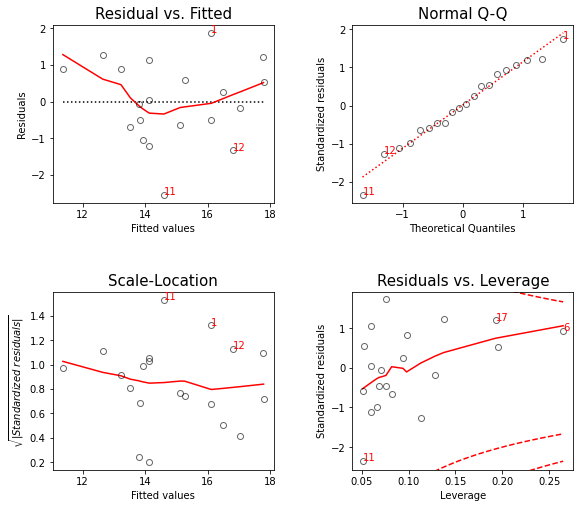

In [31]:
plt.figure(figsize=(8,7))
lmdiag.plot(res_no)
pass

外れ値（赤の観測値）がある場合の回帰診断

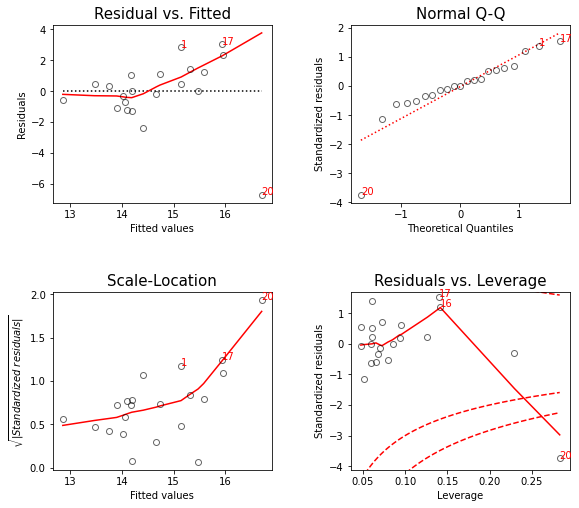

In [32]:
plt.figure(figsize=(8,7))
lmdiag.plot(res_cd)
pass

観測値`20`が非常に影響力が高いことが分かる。その観測値を取り出すには以下のようにする。
* 右下の図で`CD`の赤い点線の外（右下）にある観測値のインデックスは`20`であり、他の図でも`20`は他の観測値と比べると「外れ値」の疑いが高いことがわかる。インデックス`20`を使い観測値を抽出する。

In [33]:
df_cd.iloc[20,:]

Y    10.0
X    30.0
Name: 20, dtype: float64